<h1><center>Проект Тарифы</center></h1>


# Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

# Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## 1. Загрузка

- Загрузим исходный датасет и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, ParameterGrid


In [2]:
users_behavior = pd.read_csv('/datasets/users_behavior.csv')

users_behavior.info()

display(users_behavior)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


## 2. Разбейте данные на выборки

- Перед началом исследования зададим значение генератора псевдослучаных значений

In [3]:
random_state = 11111

- Оценим представление классов (is_ultra) в исходном датасете

In [4]:
print('Количество данных класса "Ultra":', len(users_behavior.query('is_ultra==1')))
print('Количество данных класса "Smart":', len(users_behavior.query('is_ultra==0')))

Количество данных класса "Ultra": 985
Количество данных класса "Smart": 2229


- Классы представлены неравномерно, что может вызвать "перекос" в процессе обучения, т.е. один из классов может считаться наиболее вероятным


- Для более равномерного распределения классов при обучении воспользуемся процедурой кросс-валидации:
    - Датасет перемешивается
    - Разделяется на N групп 
    - На N-1 группе производится обучение, а на оставшемся тестируется
    - Процедура повторяется N раз, меня на каждой итерации группы для тестирования и обучения
    - Осреднение оценок качества по всем итерациям повысит достоверность итоговой

- Разобъем данные на две выборки в стандартном соотношении - обучающую (80%),  и тестовую (20%)

In [5]:
df_train, df_test = train_test_split(users_behavior, test_size=0.2, random_state=random_state)

print()
print('----- Обучающая выборка: -----')
print()
df_train.info()

print()
print('----- Тестовая выборка: -----')
print()
df_test.info()


----- Обучающая выборка: -----

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2571 entries, 179 to 804
Data columns (total 5 columns):
calls       2571 non-null float64
minutes     2571 non-null float64
messages    2571 non-null float64
mb_used     2571 non-null float64
is_ultra    2571 non-null int64
dtypes: float64(4), int64(1)
memory usage: 120.5 KB

----- Тестовая выборка: -----

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643 entries, 33 to 2208
Data columns (total 5 columns):
calls       643 non-null float64
minutes     643 non-null float64
messages    643 non-null float64
mb_used     643 non-null float64
is_ultra    643 non-null int64
dtypes: float64(4), int64(1)
memory usage: 30.1 KB


- Для кросс-валидации обучающей выборки используем алгоритм стратифицированной выборки, т.е. в каждой группе распределение классов будет схожим, чтобы в одну из групп не попало слишком много значений одного класса


- Количество групп в кросс-валидации выберем равным 5 

In [6]:
cv = StratifiedShuffleSplit(n_splits=5, random_state=random_state)

## 3. Исследуйте модели

- Перед нами стоит задача классификации


- Целевой признак:


    - is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)


- Признаками для обучения модели являются:


    - сalls — количество звонков
    - minutes — суммарная длительность звонков в минутах
    - messages — количество sms-сообщений
    - mb_used — израсходованный интернет-трафик в Мб

In [7]:
train_features = df_train.drop(['is_ultra'], axis=1)
train_target = df_train['is_ultra']

test_features = df_test.drop(['is_ultra'], axis=1)
test_target = df_test['is_ultra']

- Для решения задачи методами машинного обучения мы можем воспользоваться одной из трех моделей:

    1. Дерево решений
    2. Случайный лес
    3. Логическая регрессия


- Метрикой качества модели будет значение accuracy - доля правильных ответов по тестовой/валидационной выборке


- Попробуем протестировать каждую из моделей 

### Модель: дерево решений

- Зададим модель решающего дерева

In [8]:
tree_model = DecisionTreeClassifier(random_state=random_state)

- Рассмотрим параметры заданной модели

In [9]:
tree_model.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

- Зададим параметры для подбора

In [10]:
tree_parameters_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1, 10), 
    'max_features' : ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf' :  range(1, 10),
    'min_samples_split' : range(2, 10),
    'splitter' : ['best', 'random']
} 

- Теперь мы можем посчитать качество классификации модели со всеми комбинациями заданных параметров, чтобы выбрать лучшую

- Зададим объект grid_search, для которого укажем выбранный тип модели, грид параметров для перебора, метрику качества и стратегию кросс-валидации  

In [11]:
tree_grid_cv = GridSearchCV(tree_model, tree_parameters_grid, scoring='accuracy', cv=cv)

- Обучим модели с разными параметрами и измерим общее время счета 

In [12]:
%%time
tree_grid_cv.fit(train_features, train_target)

CPU times: user 5min 29s, sys: 904 ms, total: 5min 30s
Wall time: 5min 31s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=11111, test_size=None,
            train_size=None),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_wei...
                                              presort=False, random_state=11111,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gin

In [13]:
print('Accuracy наилучшей модели на кросс-валидационной выборке:', tree_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке:')
print()
print(tree_grid_cv.best_params_)

Accuracy наилучшей модели на кросс-валидационной выборке: 0.7945736434108527

Параметры для наилучшей модели на кросс-валидационной выборке:

{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2, 'splitter': 'best'}


- Определили точность и оптимальные параметры лучшей модели


- Дополительно рассмотрим все решения  

In [14]:
tree_results = pd.DataFrame(tree_grid_cv.cv_results_)

display(tree_results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(10))

print()
print('Наилучшее решение достигается при', len(tree_results.query('mean_test_score==@tree_grid_cv.best_score_')), 'вариантах параметризации')

,params,mean_test_score
4018,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.794574
4024,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.794574
4020,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.794574
4596,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.794574
4606,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.794574
4604,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.794574
4030,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.794574
4592,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.794574
4028,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.794574
4026,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.794574



Наилучшее решение достигается при 16 вариантах параметризации


- Как видно из таблици решений, наиулчшая точность достигается при нескольких возможных параметризациях (16)


- Построим график зависимости всех получившихся моделей от качества, чтобы оценить распределение точности при переборе выбранных параметров

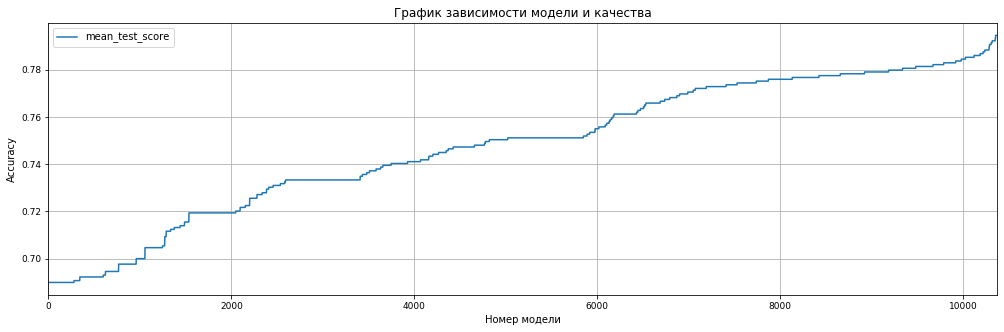

In [15]:
title = 'График зависимости модели и качества'
ax = tree_results.sort_values(by='mean_test_score').reset_index().plot(y='mean_test_score', figsize=(17,5), title=title, fontsize=9, style='-', grid=True)
ax.set(xlabel='Номер модели', ylabel='Accuracy')
plt.show()

- Максимальные значения точности достаточно уверенно выделяются на фоне остальных 

- Наилучшее значение точности превышает минимально допустимое 0.75

### Модель: случайный лес

- Зададим модель слуйчайный лес

In [16]:
random_forest_model = RandomForestClassifier(random_state=random_state)

- Рассмотрим параметры заданной модели

In [17]:
random_forest_model.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

- Зададим параметры для подбора

In [18]:
random_forest_parameters_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(1, 10),
    'max_features' : ['auto', 'sqrt', 'log2', None],
    'min_samples_leaf' :  range(1, 10),
    'n_estimators' :  range(1, 10)
} 

- Модель "случайный лес" за счет использования большого количества независимых деревьев более ресурсозатратная по сравнению с моделью "решающее дерево"


- Чтобы сократить время поиска оптимальных параметров по заданному гриду, воспользуемся подходом randomized search, позволяющим отбросить значения параметров при которых достигается заведомо низкая точность модели


- Таким образом, мы сузим количество исследуемых параметров и затем снова произведем поиск по сетке с помощью GridSearchCV

- Посчитаем сколько точек мы проверяем по общей сетке параметров


- Для этого найдем все возможные комбинации заданных параметров:


    - 'criterion' : 2 варианта
    - 'max_depth' : 10 вариантов
    - 'max_features' : 4 варианта
    - 'min_samples_leaf' :  10 вариантов
    - 'n_estimators' :  10 вариантов

In [19]:
random_forest_grid_points = ParameterGrid(random_forest_parameters_grid)
print('Количество точек сетки для модели "случайный лес":', len(random_forest_grid_points))

Количество точек сетки для модели "случайный лес": 5832


- Исследуем в 100 раз меньше точек

In [20]:
random_forest_random_grid_cv = RandomizedSearchCV(random_forest_model, random_forest_parameters_grid, n_iter=50, scoring='accuracy', cv=cv)

- Обучим модели с разными параметрами и измерим общее время счета 

In [21]:
%%time
random_forest_random_grid_cv.fit(train_features, train_target)

CPU times: user 7.45 s, sys: 36 ms, total: 7.49 s
Wall time: 7.54 s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=11111, test_size=None,
            train_size=None),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_...
                                                    random_state=11111,
                                          

In [22]:
print('Accuracy наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:', random_forest_random_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:')
print()
print(random_forest_random_grid_cv.best_params_)

Accuracy наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV: 0.7968992248062016

Параметры для наилучшей модели на кросс-валидационной выборке с использованием RandomizedSearchCV:

{'n_estimators': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'gini'}


- Рассмотрим получившиеся модели и попробуем сузить колчество параметров для оптмизации

In [23]:
random_forest_random_results = pd.DataFrame(random_forest_random_grid_cv.cv_results_)

display(random_forest_random_results.sort_values(by='mean_test_score', ascending=False).head(10))


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.019371,0.000879,0.002831,0.000511,4,5,sqrt,9,gini,"{'n_estimators': 4, 'min_samples_leaf': 5, 'ma...",0.810078,0.794574,0.802326,0.806202,0.771318,0.796899,0.013780,1
46,0.024905,0.000974,0.002505,0.000121,6,5,log2,7,gini,"{'n_estimators': 6, 'min_samples_leaf': 5, 'ma...",0.794574,0.794574,0.813953,0.798450,0.779070,0.796124,0.011126,2
30,0.053238,0.000626,0.004935,0.000262,8,4,auto,8,gini,"{'n_estimators': 8, 'min_samples_leaf': 4, 'ma...",0.786822,0.798450,0.802326,0.813953,0.779070,0.796124,0.012158,2
34,0.035123,0.006925,0.003476,0.000759,8,7,auto,6,gini,"{'n_estimators': 8, 'min_samples_leaf': 7, 'ma...",0.782946,0.817829,0.813953,0.794574,0.767442,0.795349,0.018893,4
4,0.030858,0.001005,0.002975,0.000213,8,9,auto,5,entropy,"{'n_estimators': 8, 'min_samples_leaf': 9, 'ma...",0.802326,0.790698,0.810078,0.790698,0.767442,0.792248,0.014419,5
7,0.036227,0.000930,0.002740,0.000045,7,4,sqrt,9,entropy,"{'n_estimators': 7, 'min_samples_leaf': 4, 'ma...",0.782946,0.790698,0.806202,0.798450,0.782946,0.792248,0.009040,5
5,0.055505,0.001170,0.003222,0.000402,9,2,None,8,gini,"{'n_estimators': 9, 'min_samples_leaf': 2, 'ma...",0.786822,0.802326,0.802326,0.779070,0.786822,0.791473,0.009302,7
48,0.026897,0.000769,0.002574,0.000176,6,1,sqrt,8,gini,"{'n_estimators': 6, 'min_samples_leaf': 1, 'ma...",0.790698,0.794574,0.794574,0.794574,0.779070,0.790698,0.006005,8
16,0.040114,0.001046,0.004033,0.001530,9,2,sqrt,6,entropy,"{'n_estimators': 9, 'min_samples_leaf': 2, 'ma...",0.794574,0.786822,0.821705,0.786822,0.759690,0.789922,0.019824,9
13,0.019164,0.000373,0.002352,0.000251,4,9,sqrt,6,entropy,"{'n_estimators': 4, 'min_samples_leaf': 9, 'ma...",0.790698,0.790698,0.810078,0.775194,0.782946,0.789922,0.011602,9


- Зададим новую сетку параметров 

In [24]:
random_forest_parameters_grid = {
    'criterion' : ['gini'],
    'max_depth' : range(7, 9),
    'max_features' : ['sqrt', 'log2'],
    'min_samples_leaf' :  range(1, 4),
    'n_estimators' :  range(6, 8)
} 

- Посчитаем сколько точек мы проверяем по общей сетке параметров

In [25]:
random_forest_grid_points = ParameterGrid(random_forest_parameters_grid)
print('Количество точек сетки для модели "случайный лес":', len(random_forest_grid_points))

Количество точек сетки для модели "случайный лес": 24


- Таким образом мы сократили количество точек для проверки почти в 6 раз


- Теперь мы можем посчитать качество классификации модели со всеми комбинациями заданных параметров, чтобы выбрать лучшую

In [26]:
random_forest_grid_cv = GridSearchCV(random_forest_model, random_forest_parameters_grid, scoring='accuracy', cv=cv)

- Обучим модели с разными параметрами и измерим общее время счета 

In [27]:
%%time
random_forest_grid_cv.fit(train_features, train_target)

CPU times: user 3.71 s, sys: 7.98 ms, total: 3.72 s
Wall time: 3.72 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=11111, test_size=None,
            train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sample...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=11111, verbose=0,
                                              warm_s

In [28]:
print('Accuracy наилучшей модели на кросс-валидационной выборке:', random_forest_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке:')
print()
print(random_forest_grid_cv.best_params_)

Accuracy наилучшей модели на кросс-валидационной выборке: 0.8

Параметры для наилучшей модели на кросс-валидационной выборке:

{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 6}


- Лучшая точность модели, посчитанная по полной сетке, получилась немного выше, чем по разряженной сетке  


- Определили точность и оптимальные параметры лучшей модели


- Дополительно рассмотрим все решения  

In [29]:
random_forest_results = pd.DataFrame(random_forest_grid_cv.cv_results_)

display(random_forest_results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(10))

print()
print('Наилучшее решение достигается при', len(random_forest_results.query('mean_test_score==@random_forest_grid_cv.best_score_')), 'вариантах параметризации')

,params,mean_test_score
0,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.800000
6,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.800000
7,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.799225
1,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.799225
3,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.796899
4,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.796899
9,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.796899
10,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.796899
13,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.793023
19,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.793023



Наилучшее решение достигается при 2 вариантах параметризации


- Как видно из таблици решений, наиулчшая точность достигается при двух возможных параметризациях


- Построим график зависимости всех получившихся моделей от качества, чтобы оценить распределение точности при переборе выбранных параметров

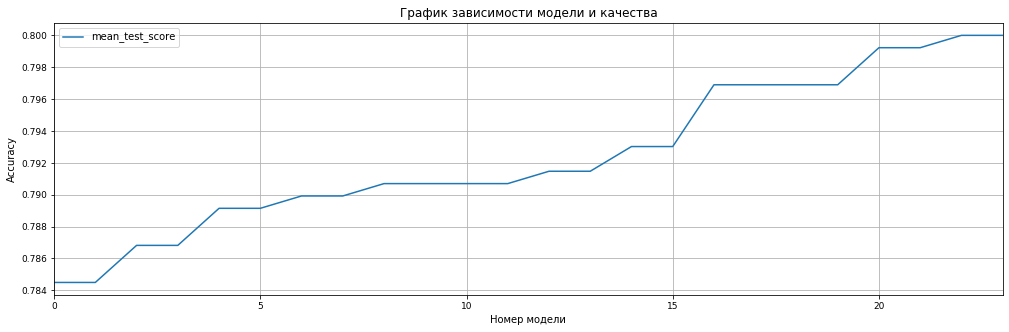

In [30]:
title = 'График зависимости модели и качества'
ax = random_forest_results.sort_values(by='mean_test_score').reset_index().plot(y='mean_test_score', figsize=(17,5), title=title, fontsize=9, style='-', grid=True)
ax.set(xlabel='Номер модели', ylabel='Accuracy')
plt.show()

- Максимальные значения точности достаточно уверенно выделяются на фоне остальных 

- Наилучшее значение точности превышает минимально допустимое 0.75

### Модель: логистическая регрессия

- Зададим модель логистической регрессии

In [31]:
logic_regression_model = LogisticRegression(random_state=random_state) 

- Рассмотрим параметры заданной модели

In [32]:
logic_regression_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

- Зададим параметры для подбора

In [33]:
logic_regression_parameters_grid = {
    'penalty' : ['none', 'l2'],
    'solver' : ['lbfgs'],
    'multi_class' : ['auto', 'ovr', 'multinomial'],
    'max_iter' : range(100, 200, 10)
}

- Теперь мы можем посчитать качество классификации модели со всеми комбинациями заданных параметров, чтобы выбрать лучшую


- Зададим объект grid_search, для которого укажем выбранный тип модели, грид параметров для перебора, метрику качества и стратегию кросс-валидации


- Для данной модели мы задали не так много параметров и их возможных комбинаций, поэтому можем сразу начать считать на полной сетке

In [34]:
logic_regression_grid_cv = GridSearchCV(logic_regression_model, logic_regression_parameters_grid, scoring='accuracy', cv=cv)

- Обучим модели с разными параметрами и измерим общее время счета 

In [35]:
%%time
logic_regression_grid_cv.fit(train_features, train_target)


CPU times: user 1min 7s, sys: 55.4 s, total: 2min 3s
Wall time: 2min 3s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=11111, test_size=None,
            train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=11111, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_iter': range(100, 200, 10),
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['none', 'l2'], 'solver': ['lbfgs']},
             pre_dispatch='

In [36]:
print('Accuracy наилучшей модели на кросс-валидационной выборке:', logic_regression_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке:')
print()
print(logic_regression_grid_cv.best_params_)

Accuracy наилучшей модели на кросс-валидационной выборке: 0.7255813953488373

Параметры для наилучшей модели на кросс-валидационной выборке:

{'max_iter': 100, 'multi_class': 'auto', 'penalty': 'none', 'solver': 'lbfgs'}


- Определили точность и оптимальные параметры лучшей модели


- Дополительно рассмотрим все решения 

In [37]:
logic_regression_results = pd.DataFrame(logic_regression_grid_cv.cv_results_)

display(logic_regression_results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(10))

print()
print('Наилучшее решение достигается при', len(tree_results.query('mean_test_score==@logic_regression_grid_cv.best_score_')), 'вариантах параметризации')

,params,mean_test_score
0,"{'max_iter': 100, 'multi_class': 'auto', 'pena...",0.725581
25,"{'max_iter': 140, 'multi_class': 'auto', 'pena...",0.725581
27,"{'max_iter': 140, 'multi_class': 'ovr', 'penal...",0.725581
1,"{'max_iter': 100, 'multi_class': 'auto', 'pena...",0.725581
31,"{'max_iter': 150, 'multi_class': 'auto', 'pena...",0.725581
32,"{'max_iter': 150, 'multi_class': 'ovr', 'penal...",0.725581
33,"{'max_iter': 150, 'multi_class': 'ovr', 'penal...",0.725581
36,"{'max_iter': 160, 'multi_class': 'auto', 'pena...",0.725581
37,"{'max_iter': 160, 'multi_class': 'auto', 'pena...",0.725581
38,"{'max_iter': 160, 'multi_class': 'ovr', 'penal...",0.725581



Наилучшее решение достигается при 80 вариантах параметризации


- Как видно из таблици решений, наиулчшая точность достигается при нескольких возможных параметризациях (80)


- Построим график зависимости всех получившихся моделей от качества, чтобы оценить распределение точности при переборе выбранных параметров

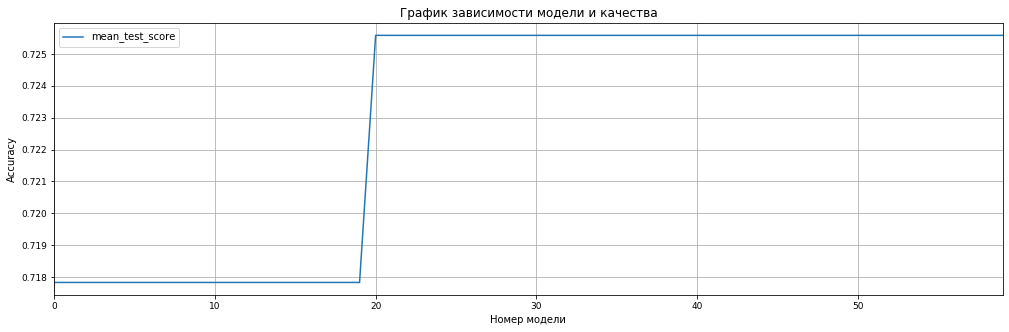

In [38]:
title = 'График зависимости модели и качества'
ax = logic_regression_results.sort_values(by='mean_test_score').reset_index().plot(y='mean_test_score', figsize=(17,5), title=title, fontsize=9, style='-', grid=True)
ax.set(xlabel='Номер модели', ylabel='Accuracy')
plt.show()

- Результаты обучения неудовлетворительные


- На графике точность модели меняется скачкообразно, при этом значения выходят на постоянные значения


- Следовательно перебор параметров стоит пересмотреть

In [39]:
display(logic_regression_results.sort_values(by='mean_test_score', ascending=False))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,param_multi_class,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.630072,0.178980,0.002639,0.000027,100,auto,none,lbfgs,"{'max_iter': 100, 'multi_class': 'auto', 'pena...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
25,0.520214,0.191774,0.020062,0.034941,140,auto,l2,lbfgs,"{'max_iter': 140, 'multi_class': 'auto', 'pena...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
27,0.482844,0.169358,0.002139,0.000463,140,ovr,l2,lbfgs,"{'max_iter': 140, 'multi_class': 'ovr', 'penal...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
1,0.618106,0.174908,0.002631,0.000082,100,auto,l2,lbfgs,"{'max_iter': 100, 'multi_class': 'auto', 'pena...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
31,0.514222,0.145407,0.002598,0.000142,150,auto,l2,lbfgs,"{'max_iter': 150, 'multi_class': 'auto', 'pena...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
32,0.522520,0.202284,0.020046,0.035386,150,ovr,none,lbfgs,"{'max_iter': 150, 'multi_class': 'ovr', 'penal...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
33,0.498391,0.186253,0.002359,0.000427,150,ovr,l2,lbfgs,"{'max_iter': 150, 'multi_class': 'ovr', 'penal...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
36,0.561541,0.154035,0.002635,0.000064,160,auto,none,lbfgs,"{'max_iter': 160, 'multi_class': 'auto', 'pena...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
37,0.498897,0.163709,0.020592,0.035115,160,auto,l2,lbfgs,"{'max_iter': 160, 'multi_class': 'auto', 'pena...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1
38,0.617017,0.235380,0.002673,0.000090,160,ovr,none,lbfgs,"{'max_iter': 160, 'multi_class': 'ovr', 'penal...",0.751938,0.748062,0.678295,0.744186,0.705426,0.725581,0.028943,1


- Можно заметить, что при значении параметра multi_class = multinomial достигаются наименьшие значения точности


- Попробуем подобрать другие параметры для перебора

In [40]:
logic_regression_parameters_grid = {
    'penalty' : ['l2', 'l1'],
    'solver' : ['liblinear'],
    'multi_class' : ['auto', 'ovr']
}

In [41]:
logic_regression_grid_cv = GridSearchCV(logic_regression_model, logic_regression_parameters_grid, scoring='accuracy', cv=cv)

In [42]:
%%time
logic_regression_grid_cv.fit(train_features, train_target)

CPU times: user 311 ms, sys: 5.32 ms, total: 316 ms
Wall time: 327 ms


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=11111, test_size=None,
            train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=11111, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'multi_class': ['auto', 'ovr'],
                         'penalty': ['l2', 'l1'], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='

In [43]:
print('Accuracy наилучшей модели на кросс-валидационной выборке:', logic_regression_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке:')
print()
print(logic_regression_grid_cv.best_params_)

Accuracy наилучшей модели на кросс-валидационной выборке: 0.7410852713178294

Параметры для наилучшей модели на кросс-валидационной выборке:

{'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}


- Лучшая точность повысилась по сравнению с предыдущим исследованием 


- Согласно описанию функции алгоритм 'liblinear' больше всего подходит для небольших датасетов, как в нашем случае


- Тем не менее, точность все еще ниже минимально допустимой - 0.75


- Попробуем улучшить результат

In [44]:
logic_regression_results = pd.DataFrame(logic_regression_grid_cv.cv_results_)

display(logic_regression_results.sort_values(by='mean_test_score', ascending=False))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multi_class,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.009614,0.001579,0.001325,0.000025,auto,l1,liblinear,"{'multi_class': 'auto', 'penalty': 'l1', 'solv...",0.751938,0.748062,0.732558,0.740310,0.732558,0.741085,0.007905,1
3,0.009906,0.001277,0.001400,0.000079,ovr,l1,liblinear,"{'multi_class': 'ovr', 'penalty': 'l1', 'solve...",0.751938,0.748062,0.732558,0.740310,0.732558,0.741085,0.007905,1
0,0.018107,0.007164,0.001267,0.000040,auto,l2,liblinear,"{'multi_class': 'auto', 'penalty': 'l2', 'solv...",0.697674,0.697674,0.724806,0.693798,0.728682,0.708527,0.014992,3
2,0.015908,0.002595,0.001410,0.000092,ovr,l2,liblinear,"{'multi_class': 'ovr', 'penalty': 'l2', 'solve...",0.697674,0.697674,0.724806,0.693798,0.728682,0.708527,0.014992,3


- Можно отметить, что норма l1 дает наибольшие значения точности


- Значени параметра multi_class дают одинаковые результаты


- Введем дополнительные параметры 

In [45]:
logic_regression_parameters_grid = {
    'penalty' : ['l1'],
    'solver' : ['liblinear'],
    'multi_class' : ['ovr'],
    'C' : np.linspace(0.1, 2, num=20)
}

In [46]:
logic_regression_grid_cv = GridSearchCV(logic_regression_model, logic_regression_parameters_grid, scoring='accuracy', cv=cv)

In [47]:
%%time
logic_regression_grid_cv.fit(train_features, train_target)

CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.26 s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=11111, test_size=None,
            train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=11111, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
                         'multi_class': ['ovr'], 'penalty': ['l1'],
                 

In [48]:
print('Accuracy наилучшей модели на кросс-валидационной выборке:', logic_regression_grid_cv.best_score_)
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке:')
print()
print(logic_regression_grid_cv.best_params_)

Accuracy наилучшей модели на кросс-валидационной выборке: 0.7426356589147287

Параметры для наилучшей модели на кросс-валидационной выборке:

{'C': 1.9, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


- Лучшая точность немного повысилась по сравнению с предыдущим исследованием, но она все же меньше минимальной  

In [49]:
logic_regression_results = pd.DataFrame(logic_regression_grid_cv.cv_results_)

display(logic_regression_results.sort_values(by='mean_test_score', ascending=False).head(10))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_multi_class,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.011298,0.001199,0.001637,0.000391,2,ovr,l1,liblinear,"{'C': 2.0, 'multi_class': 'ovr', 'penalty': 'l...",0.755814,0.751938,0.732558,0.74031,0.732558,0.742636,0.009682,1
18,0.011293,0.002246,0.001354,0.000092,1.9,ovr,l1,liblinear,"{'C': 1.9, 'multi_class': 'ovr', 'penalty': 'l...",0.755814,0.751938,0.732558,0.74031,0.732558,0.742636,0.009682,1
11,0.010419,0.000377,0.001612,0.000351,1.2,ovr,l1,liblinear,"{'C': 1.2, 'multi_class': 'ovr', 'penalty': 'l...",0.755814,0.748062,0.732558,0.74031,0.732558,0.741860,0.009040,3
17,0.010286,0.001211,0.001447,0.000242,1.8,ovr,l1,liblinear,"{'C': 1.8, 'multi_class': 'ovr', 'penalty': 'l...",0.755814,0.748062,0.732558,0.74031,0.732558,0.741860,0.009040,3
16,0.009431,0.001114,0.001348,0.000249,1.7,ovr,l1,liblinear,"{'C': 1.7, 'multi_class': 'ovr', 'penalty': 'l...",0.755814,0.748062,0.732558,0.74031,0.732558,0.741860,0.009040,3
15,0.009953,0.001187,0.001357,0.000053,1.6,ovr,l1,liblinear,"{'C': 1.5999999999999999, 'multi_class': 'ovr'...",0.755814,0.748062,0.732558,0.74031,0.732558,0.741860,0.009040,3
14,0.009869,0.000984,0.001333,0.000160,1.5,ovr,l1,liblinear,"{'C': 1.5, 'multi_class': 'ovr', 'penalty': 'l...",0.755814,0.748062,0.732558,0.74031,0.732558,0.741860,0.009040,3
13,0.009349,0.001218,0.001210,0.000020,1.4,ovr,l1,liblinear,"{'C': 1.4, 'multi_class': 'ovr', 'penalty': 'l...",0.755814,0.748062,0.732558,0.74031,0.732558,0.741860,0.009040,3
12,0.010124,0.001334,0.001375,0.000074,1.3,ovr,l1,liblinear,"{'C': 1.3, 'multi_class': 'ovr', 'penalty': 'l...",0.755814,0.748062,0.732558,0.74031,0.732558,0.741860,0.009040,3
10,0.009336,0.001002,0.001559,0.000327,1.1,ovr,l1,liblinear,"{'C': 1.0999999999999999, 'multi_class': 'ovr'...",0.755814,0.748062,0.732558,0.74031,0.732558,0.741860,0.009040,3


- Наилучшее значение точности не превышает минимально допустимое 0.75


- Вероятно данная модель обучения либо не очень подходит, либо требует дальнейшего изучения для повышения качества

## 4. Проверьте модель на тестовой выборке

- Перед началом проверки оценим соотношение классов в обучающей и тестовой выборке

In [50]:
df_pivot = df_train.pivot_table(index='is_ultra', values='calls', aggfunc='count')
df_test_pivot = df_test.pivot_table(index='is_ultra', values='calls', aggfunc='count')

df_pivot['test_class_count'] = df_test_pivot
df_pivot.columns=['train_class_count', 'test_class_count']
display(df_pivot)

train_class_ratio = df_pivot.iloc[0, 0]/df_pivot.iloc[1, 0]
test_class_ratio = df_pivot.iloc[0, 1]/df_pivot.iloc[1, 1]

print('Соотношение классов в обучающей выборке: {:.2f}'.format(train_class_ratio))
print('Соотношение классов в тестовой выборке: {:.2f}'.format(test_class_ratio))


,train_class_count,test_class_count
is_ultra,,
0,1777,452
1,794,191


Соотношение классов в обучающей выборке: 2.24
Соотношение классов в тестовой выборке: 2.37


- Соотношение классов в обучающей и тестовой выборке схоже

- Перейдем к проверке лучших моделей на тестовой выборке

In [51]:
%%time

tree_model = DecisionTreeClassifier(random_state=random_state, criterion='gini', max_depth=7, max_features=None, min_samples_leaf=9, min_samples_split=2, splitter='best')

tree_model.fit(train_features, train_target)
tree_result = tree_model.score(test_features, test_target)
print("---- Accuracy модели решающее дерево на тестовой выборке:", tree_result, '----')

---- Accuracy модели решающее дерево на тестовой выборке: 0.80248833592535 ----
CPU times: user 6.15 ms, sys: 8.69 ms, total: 14.8 ms
Wall time: 12.6 ms


In [52]:
%%time

random_forest_model = RandomForestClassifier(random_state=random_state, criterion='gini', max_depth=7, max_features='sqrt', min_samples_leaf=1, n_estimators=6)

random_forest_model.fit(train_features, train_target)
random_forest_result = random_forest_model.score(test_features, test_target)
print("---- Accuracy модели случайный лес на тестовой выборке:", random_forest_result, '----')

---- Accuracy модели случайный лес на тестовой выборке: 0.8149300155520995 ----
CPU times: user 34.1 ms, sys: 61 µs, total: 34.2 ms
Wall time: 60.4 ms


In [53]:
%%time

logic_regression_model = LogisticRegression(random_state=random_state, C=1.9, multi_class='ovr', penalty='l1', solver='liblinear') 

logic_regression_model.fit(train_features, train_target)
logic_regression_result = logic_regression_model.score(test_features, test_target)
print("---- Accuracy модели логистической регрессии на тестовой выборке:", logic_regression_result, '----')

---- Accuracy модели логистической регрессии на тестовой выборке: 0.7651632970451011 ----
CPU times: user 13.7 ms, sys: 3.78 ms, total: 17.5 ms
Wall time: 15.4 ms


- Объединим данные в общую таблицу

In [54]:
d = {'Модель': ['Решающее дерево', 'Случайный лес', 'Логическая регрессия'], 
     'Точность': [tree_result, random_forest_result, logic_regression_result],
     'Время, мс' : [13.3, 30.4, 16.8],
     'Качество точности' : ['среднее', 'высокое', 'низкое'],
     'Качество скорости счета' : ['высокое', 'низкое', 'среднее'],
     'Оптимальные параметры' : [tree_grid_cv.best_params_, random_forest_grid_cv.best_params_, logic_regression_grid_cv.best_params_]}

model_results = pd.DataFrame(data=d)

display(model_results.set_index('Модель').sort_values(by='Точность', ascending=False).round(3))

,Точность,"Время, мс",Качество точности,Качество скорости счета,Оптимальные параметры
Модель,,,,,
Случайный лес,0.815,30.4,высокое,низкое,"{'criterion': 'gini', 'max_depth': 7, 'max_fea..."
Решающее дерево,0.802,13.3,среднее,высокое,"{'criterion': 'gini', 'max_depth': 7, 'max_fea..."
Логическая регрессия,0.765,16.8,низкое,среднее,"{'C': 1.9, 'multi_class': 'ovr', 'penalty': 'l..."


- Исходя из приведенных данных, можно сделать следующие выводы:

    1. Наилучшая точность достигается на модели "случайный лес" - 0.81
    
    2. По соотношению точность/скорость счета лидирует модель "решающее дерево" - при разнице в точности ~1% по сравнению со "случайным лесом", скорость отличается более чем в 2 раза
    
    3. Модель "логическая регрессия" показала самое низкое значение точности

## 5. (бонус) Проверьте модели на адекватность

- Мы используем машинное обучение для решения задачи, чтобы попытаться создать модель максимально приближенную к какому-либо процессу


- Тем самым с помощью такой модели мы хотим как можно более достоверно предсказывать результаты процесса на основе некоторых входных данных  


- Чем лучше модель описывает процесс, тем выше точность ее предсказания. 


- Адекватность модели мы можем оценить по степени ее приближения к описанию исследуемого процесса. Будь точность модели равна 1, она бы полностью представляла собой сам процесс или, наоборот, если ее точность меньше, чем у случайной модели, то она очень слабо отражает поведение процесса


- Случайная модель пытается угадать ответ на основе распределения классов, т.е. допусим в нашем датасете соотношение классов в обучающей выборке 3:2. тогда случайная модель будет считать, что первый класс можно встретить с вероятностью 60% , а второй - 40%


- Оценим точность случайной модели 

In [55]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_features, train_target)

dummy_clf.predict(train_features)

dummy_clf_results = dummy_clf.score(train_features, train_target)

print('Точность предсказания случайной модели: {:.2f}'.format(dummy_clf_results))

Точность предсказания случайной модели: 0.69


In [56]:
display(model_results.set_index('Модель').sort_values(by='Точность', ascending=False).round(3))

,Точность,"Время, мс",Качество точности,Качество скорости счета,Оптимальные параметры
Модель,,,,,
Случайный лес,0.815,30.4,высокое,низкое,"{'criterion': 'gini', 'max_depth': 7, 'max_fea..."
Решающее дерево,0.802,13.3,среднее,высокое,"{'criterion': 'gini', 'max_depth': 7, 'max_fea..."
Логическая регрессия,0.765,16.8,низкое,среднее,"{'C': 1.9, 'multi_class': 'ovr', 'penalty': 'l..."


- Точности всех моделей превосходят точность случайной, следовательно их можно считать адекватными


- При этом, модель "случайный лес" наилучшим образом описывает наш процесс 

## Общий вывод

    1. Наилучшая точность достигается на модели "случайный лес" - 0.81
    
    2. По соотношению точность/скорость счета лидирует модель "решающее дерево" - при разнице в точности ~1% по сравнению со "случайным лесом", скорость отличается более чем в 2 раза
    
    3. Модель "логическая регрессия" показала самое низкое значение точности
    
    4. Точности всех моделей превосходят точность случайной, следовательно их можно считать адекватными

    5. При этом, модель "случайный лес" наилучшим образом описывает наш процесс 
    
    6. Для поставленной задачи классификации из всех моделей рекомендую использовать "случайный лес"